In [0]:
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse 


In [1]:
from google.colab import drive
drive.mount('/content/drive')
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import tarfile as tfl

In [0]:
face_tar = 'drive/My Drive/Collab/data/lfw-funneled.tgz'
tarref = tfl.open(face_tar,'r')

In [0]:
tarref.extractall('drive/My Drive/Collab/data')

In [0]:
path_name = 'drive/My Drive/Collab/data/lfw_funneled'
link_name = []
for (rootDir, dirNames, filenames) in os.walk(path_name):
  for filename in filenames: 
    if filename.endswith('.jpg'):
      link_name.append(os.path.join(rootDir, filename))

In [47]:
print('there are {} inmages in the face collection'.format(len(link_name)))

there are 13035 inmages in the face collection


In [0]:
import random
random.seed(666)
random.shuffle(link_name)

In [0]:
face_train = link_name[:5000]
face_valid = link_name[5000:7000]

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [10]:
# Parameters for graph, image output in 4x4 configuration
nrows = 4 
ncols = 4

#Set up matplotlib fig and size to fit 4x4 image
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)


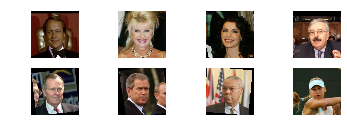

In [11]:
for i, img_path in enumerate(face_train[:8]):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [0]:
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from keras.datasets import cifar10
from keras.optimizers  import SGD
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


((xtrain, ytrain), (xtest, ytest)) = cifar10.load_data()

In [0]:
import shutil


In [0]:
train_dir = 'drive/My Drive/Collab/data/train_dir/face'
valid_dir = 'drive/My Drive/Collab/data/valid_dir/face'

os.makedirs(train_dir)
os.makedirs(valid_dir)


In [0]:
for train_img in face_train:
  shutil.move(train_img, train_dir)
for valid_img in face_valid:
  shutil.move(valid_img, valid_dir) 

In [51]:
print(xtest.shape)

(10000, 32, 32, 3)


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'drive/My Drive/Collab/data/train_dir'
valid_dir = 'drive/My Drive/Collab/data/valid_dir'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(32, 32),  # All images will be resized to 150x150
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode= None)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(32, 32),
        batch_size=1,
        class_mode= None)


Found 5004 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


In [0]:
def getValue(data_generator):
  data_list = []
  batch_index = 0

  while batch_index <= data_generator.batch_index:
    data = data_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1
  return np.array(data_list)

In [0]:
face_train = getValue(train_generator)
face_valid = getValue(validation_generator)

In [83]:
print(face_train.shape)
print(face_valid.shape)

(5004, 32, 32, 3)
(2000, 32, 32, 3)


In [84]:
print(xtest.shape)
print(xtrain.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)


In [0]:
xtrain = np.concatenate((xtrain/255,face_train), axis = 0)
xtest  = np.concatenate((xtest/255 , face_valid), axis = 0)

In [99]:
print(xtest.shape)
print(xtrain.shape)

(12000, 32, 32, 3)
(55004, 32, 32, 3)


In [87]:
print(np.unique(ytrain))

[0 1 2 3 4 5 6 7 8 9]


In [100]:
ytrain_total = np.r_[ytrain, 10*np.ones((face_train.shape[0],1)).astype('int')]
print(ytrain_total.shape)
print(np.unique(ytrain_total))

(55004, 1)
[ 0  1  2  3  4  5  6  7  8  9 10]


In [101]:
ytest_total = np.r_[ytest, 10*np.ones((face_valid.shape[0],1)).astype('int')]
print(ytest_total.shape)
print(np.unique(ytest_total))

(12000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10]


In [0]:
def MiniVGGNet(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    
    # First CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # Second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # First set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(units = 512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Softmax classifier
    model.add(Dense(units = classes))
    model.add(Activation('softmax'))
    
    return model

In [0]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y_train = lb.fit_transform(ytrain_total)
Y_test = lb.transform(ytest_total)

In [103]:
optimizer = SGD(lr = 0.01, momentum = 0.9)
model = MiniVGGNet(32, 32, 3, 11)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
H = model.fit(xtrain, Y_train, batch_size = 100, validation_data = (xtest, Y_test), verbose = 1, epochs = 20)

Train on 55004 samples, validate on 12000 samples
Epoch 1/40
55004/55004 [==============================] - 739s 13ms/step - loss: 1.6595 - acc: 0.4629 - val_loss: 1.0688 - val_acc: 0.6280
Epoch 2/40
55004/55004 [==============================] - 738s 13ms/step - loss: 1.1299 - acc: 0.6165 - val_loss: 0.9233 - val_acc: 0.6825
Epoch 3/40
55004/55004 [==============================] - 734s 13ms/step - loss: 0.9356 - acc: 0.6764 - val_loss: 0.6969 - val_acc: 0.7598
Epoch 4/40
55004/55004 [==============================] - 741s 13ms/step - loss: 0.8240 - acc: 0.7148 - val_loss: 0.9785 - val_acc: 0.6799
Epoch 5/40
55004/55004 [==============================] - 746s 14ms/step - loss: 0.7476 - acc: 0.7428 - val_loss: 0.6107 - val_acc: 0.7898
Epoch 6/40
55004/55004 [==============================] - 734s 13ms/step - loss: 0.6860 - acc: 0.7612 - val_loss: 0.5874 - val_acc: 0.7959
Epoch 7/40
55004/55004 [==============================] - 728s 13ms/step - loss: 0.6428 - acc: 0.7777 - val_loss: 0.

In [1]:
acc = H.history['acc']
val_acc = H.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = H.history['loss']
val_loss = H.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')


NameError: ignored